In [173]:
import os
import re
import importlib

import numpy as np
import matplotlib.pyplot as plt

import data_utils

# importlib.reload(data_utils)

## Load and preprocess the data

In [174]:
path = "/Users/jkamalu/Downloads/BosphorusDB"

In [175]:
# Load the data and store in dictionary

lookup_table = data_utils.process_data(path)

In [176]:
# Extract ndarray from dictionary and create index

lookup_table, landmarks, face_data = data_utils.convert_data(lookup_table)

In [177]:
# Pad the face data to max width and height with z_min

w_max = max(x.shape[1] for x in face_data)
h_max = max(x.shape[0] for x in face_data)
z_min = min(np.min(x) for x in face_data)
print("max dim:", w_max, h_max)
print("min z:", z_min)

for i, f in enumerate(face_data):
    w_pad = (w_max - f.shape[1]) // 2
    h_pad = (h_max - f.shape[0]) // 2
    f_pad = ((h_pad, h_max - f.shape[0] - h_pad), (w_pad, w_max - f.shape[1] - w_pad), (0, 0))
    face_data[i] = np.pad(f, f_pad, mode="constant", constant_values=z_min)

max dim: 194 267
min z: -1000000000.0


In [178]:
# Convert to numpy arrays

landmarks = np.array(landmarks)
face_data = np.array(face_data)

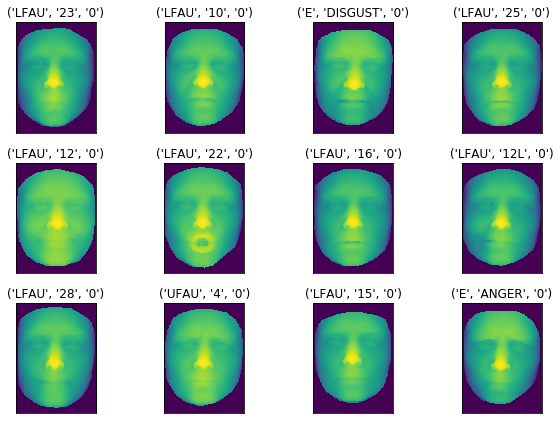

In [165]:
uid = "bs000"

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

for ax, config in zip(axs.flat, lookup_table[uid]):
    idx = lookup_table[uid][config]
    points = face_data[idx]
    min_vals = np.sort(np.unique(points[:, :, 2]))
    points[points == min_vals[0]] = min_vals[1]
    ax.imshow(points[:, :, 2])
    ax.set_title(str(config))

plt.tight_layout()
plt.show()